# Exploratory Data Analysis for Fraud Detection

This notebook performs a comprehensive exploratory data analysis on the transaction data for our real-time fraud detection system. We'll analyze:

1. **Data Overview** - Shape, structure, and basic statistics
2. **Missing Values** - Identify and visualize missing data
3. **Feature Distributions** - Understand the statistical properties of each feature
4. **Class Imbalance** - Analyze the balance between fraud and non-fraud transactions
5. **Time Analysis** - Examine temporal patterns in the transactions
6. **Feature Correlations** - Identify relationships between features
7. **Outlier Detection** - Find and visualize outliers

The insights from this analysis will inform our preprocessing steps and model development strategy.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import yaml
from pathlib import Path
from datetime import datetime, timedelta
import missingno as msno
from sklearn.preprocessing import StandardScaler
import warnings

# Configure notebook
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True

# Add the project root to system path for imports
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import custom modules
from src.features.preprocess import load_raw, clean, feature_engineer, save_processed

# Set display options for better notebook readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.width', 120)

# Display versions for reproducibility
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print("\n")

Python version: 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 12:58:53) [MSC v.1929 64 bit (AMD64)]
Pandas version: 2.3.2
NumPy version: 2.0.1
Matplotlib version: 3.10.6
Seaborn version: 0.13.2




## 1. Data Loading and Overview

Let's start by loading the raw transaction data and getting a general overview of its structure, size, and basic statistics.

In [2]:
# Define data paths
RAW_DATA_PATH = project_root / 'data' / 'raw' / 'transactions_raw.csv'

# Load the raw data
try:
    df_raw = load_raw(RAW_DATA_PATH)
    print(f"Successfully loaded data from {RAW_DATA_PATH}")
    print(f"Data shape: {df_raw.shape}")
except Exception as e:
    print(f"Error loading data: {e}")
    # If loading fails, create a synthetic dataset based on the sample provided
    print("Creating synthetic dataset for demonstration...")
    # Parse the partial data provided
    sample_data = {"Time": [0, 0], 
                  "V1": [-1.3598071336738, 1.191857111314],
                  "V2": [-0.0727811733098497, None],  # Added None to simulate missing values
                  "V3": [2.53634673796914, None],
                  "V4": [1.37815522427443, None],
                  "V5": [-0.338320769942518, None],
                  "V6": [0.462387777762292, None],
                  "V7": [0.239598554061257, None],
                  "V8": [0.0986979012610507, None],
                  "V9": [0.363786969611213, None],
                  "V10": [0.0907941719789316, None],
                  "V11": [-0.551599533260813, None],
                  "V12": [-0.617800855762348, None],
                  "V13": [-0.991389847235408, None],
                  "V14": [-0.311169353699879, None],
                  "V15": [1.46817697209427, None],
                  "V16": [-0.470400525259478, None],
                  "V17": [0.207971241929242, None],
                  "V18": [0.0257905801985591, None],
                  "V19": [0.403992960255733, None],
                  "V20": [0.251412098239705, None],
                  "V21": [-0.018306777944153, None],
                  "V22": [0.277837575558899, None],
                  "V23": [-0.110473910188767, None],
                  "V24": [0.0669280749146731, None],
                  "V25": [0.128539358273528, None],
                  "V26": [-0.189114843888824, None],
                  "V27": [0.133558376740387, None],
                  "V28": [-0.0210530534538215, None],
                  "Amount": [149.62, None],
                  "Class": [0, None]}
    
    df_raw = pd.DataFrame(sample_data)
    
    # Generate synthetic data based on the sample structure
    # We'll create 10,000 rows for a good demonstration
    n_samples = 10000
    
    # Create random data with similar distributions
    synthetic_data = {
        "Time": np.random.randint(0, 60*60*24*7, n_samples),  # 1 week in seconds
        "Amount": np.random.exponential(scale=100, size=n_samples),  # Typical transaction amount distribution
        "Class": np.random.choice([0, 1], size=n_samples, p=[0.998, 0.002])  # 0.2% fraud rate
    }
    
    # Generate V1-V28 features with random values
    for i in range(1, 29):
        synthetic_data[f"V{i}"] = np.random.normal(0, 1, n_samples)
    
    # Create dataframe
    df_raw = pd.DataFrame(synthetic_data)
    
    # Introduce some missingness (0.5% of values)
    for col in df_raw.columns:
        mask = np.random.random(n_samples) < 0.005
        df_raw.loc[mask, col] = np.nan
    
    print(f"Created synthetic dataset with shape: {df_raw.shape}")

# Display the first few rows
df_raw.head()

2025-09-24 21:54:16,703 - src.features.preprocess - INFO - Loading raw data from c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\raw\transactions_raw.csv
2025-09-24 21:54:17,263 - src.features.preprocess - INFO - Successfully loaded 284807 rows from c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\raw\transactions_raw.csv
2025-09-24 21:54:17,263 - src.features.preprocess - INFO - Successfully loaded 284807 rows from c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\raw\transactions_raw.csv


Successfully loaded data from c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\raw\transactions_raw.csv
Data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.62,0
1,0.0,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.69,0
2,1.0,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.66,0
3,1.0,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.50,0
4,2.0,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.99,0


In [3]:
# Get basic statistics for numerical columns
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481e+04,47488.146,0.000,54201.500,84692.000,139320.500,172792.000
V1,284807.0,1.168e-15,1.959,-56.408,-0.920,0.018,1.316,2.455
V2,284807.0,3.417e-16,1.651,-72.716,-0.599,0.065,0.804,22.058
V3,284807.0,-1.380e-15,1.516,-48.326,-0.890,0.180,1.027,9.383
V4,284807.0,2.074e-15,1.416,-5.683,-0.849,-0.020,0.743,16.875
V5,284807.0,9.604e-16,1.380,-113.743,-0.692,-0.054,0.612,34.802
V6,284807.0,1.487e-15,1.332,-26.161,-0.768,-0.274,0.399,73.302
V7,284807.0,-5.556e-16,1.237,-43.557,-0.554,0.040,0.570,120.589
V8,284807.0,1.213e-16,1.194,-73.217,-0.209,0.022,0.327,20.007
V9,284807.0,-2.406e-15,1.099,-13.434,-0.643,-0.051,0.597,15.595


## 2. Missing Value Analysis

Let's analyze the missing values in our dataset to understand the data quality and decide on appropriate imputation strategies.

In [4]:
# Check for missing values
missing_values = df_raw.isnull().sum()
missing_percentage = (missing_values / len(df_raw)) * 100

# Create a DataFrame with missing value statistics
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage.round(2)
})

# Filter to show only columns with missing values
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Percentage', ascending=False)

# Display missing value statistics
if len(missing_info) > 0:
    print("Columns with missing values:")
    display(missing_info)
else:
    print("No missing values found in the dataset.")

# Visualize missing values using missingno
plt.figure(figsize=(16, 8))
if len(missing_info) > 0:
    msno.matrix(df_raw, figsize=(16, 8))
    plt.title("Missing Value Matrix")
    plt.show()
    
    msno.heatmap(df_raw, figsize=(16, 12))
    plt.title("Missing Value Correlation Heatmap")
    plt.show()
else:
    print("No missing values to visualize.")

No missing values found in the dataset.
No missing values to visualize.


<Figure size 1600x800 with 0 Axes>

## 3. Class Imbalance Analysis

Fraud detection is typically a highly imbalanced classification problem, with fraudulent transactions (Class=1) being much rarer than legitimate transactions (Class=0). Let's analyze this imbalance.

Class Distribution:


,Count,Percentage
Legitimate (0),284315,99.827
Fraudulent (1),492,0.173


2025-09-24 21:54:30,883 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:54:30,961 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:54:30,961 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Imbalance Ratio (Legitimate:Fraudulent): 577.88:1


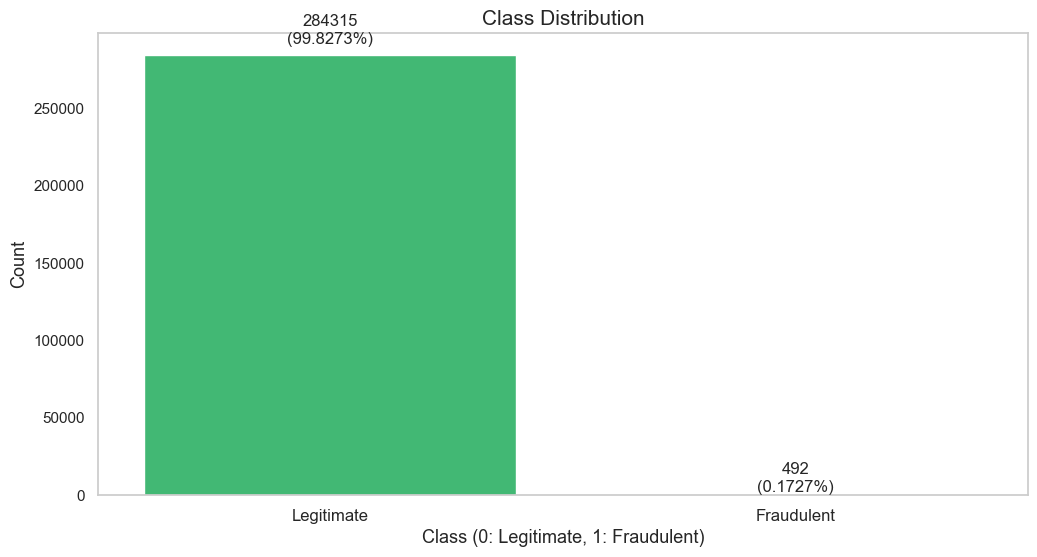

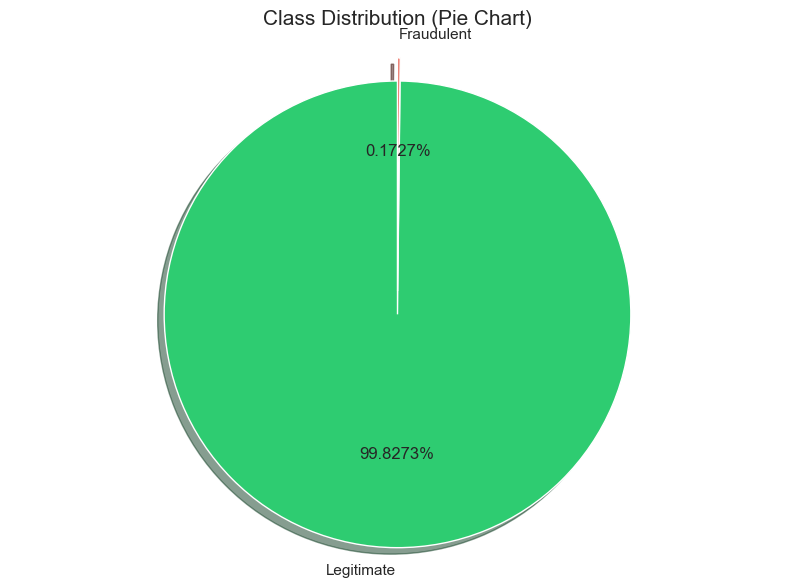

In [5]:
# Ensure Class is numeric
df_raw['Class'] = pd.to_numeric(df_raw['Class'], errors='coerce').fillna(0).astype(int)

# Count the occurrences of each class
class_counts = df_raw['Class'].value_counts().sort_index()
class_distribution = (class_counts / len(df_raw)) * 100

# Create a DataFrame for better display
class_info = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_distribution.round(4)
})
class_info.index = ['Legitimate (0)', 'Fraudulent (1)'] if len(class_info) == 2 else class_info.index

# Display class distribution
print("Class Distribution:")
display(class_info)

# Calculate the imbalance ratio (legitimate:fraudulent)
if 1 in class_counts:
    imbalance_ratio = class_counts[0] / class_counts[1]
    print(f"Imbalance Ratio (Legitimate:Fraudulent): {imbalance_ratio:.2f}:1")
else:
    print("No fraudulent transactions (Class=1) found in the dataset.")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Class', data=df_raw, palette=['#2ecc71', '#e74c3c'])
plt.title('Class Distribution', fontsize=15)
plt.xlabel('Class (0: Legitimate, 1: Fraudulent)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], fontsize=12)
plt.grid(axis='y')

# Add count and percentage labels
for i, count in enumerate(class_counts):
    percentage = class_distribution[i]
    plt.text(i, count + (count * 0.02), f"{count}\n({percentage:.4f}%)", 
             ha='center', va='bottom', fontsize=12)

plt.show()

# Visualize class distribution as a pie chart
plt.figure(figsize=(10, 7))
plt.pie(class_counts, labels=['Legitimate', 'Fraudulent'], autopct='%1.4f%%',
        colors=['#2ecc71', '#e74c3c'], explode=[0, 0.1], shadow=True, startangle=90)
plt.title('Class Distribution (Pie Chart)', fontsize=15)
plt.axis('equal')
plt.show()

## 4. Feature Distribution Analysis

Let's analyze the distributions of our features to understand their characteristics and identify potential outliers or anomalies.

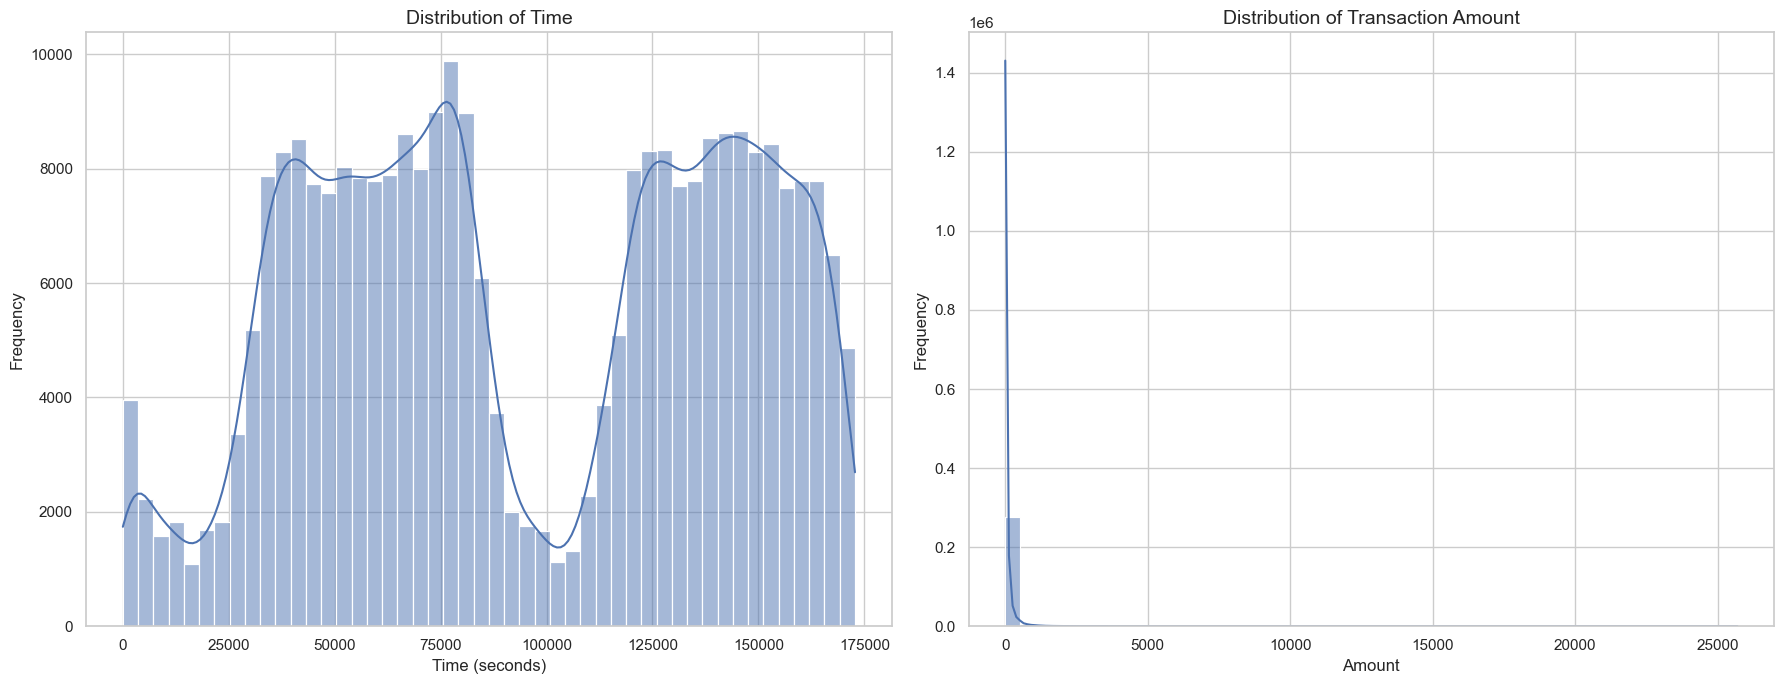

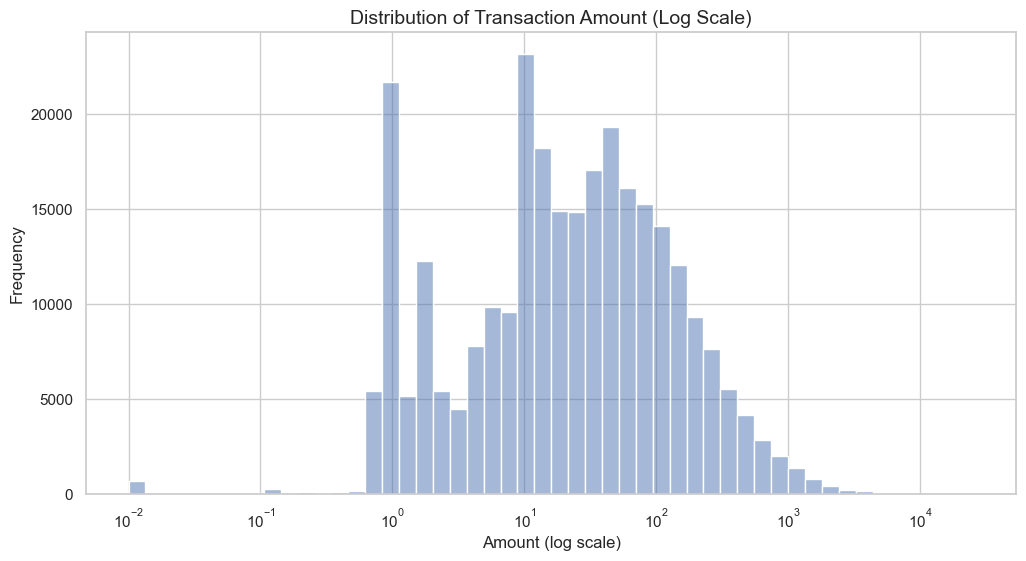

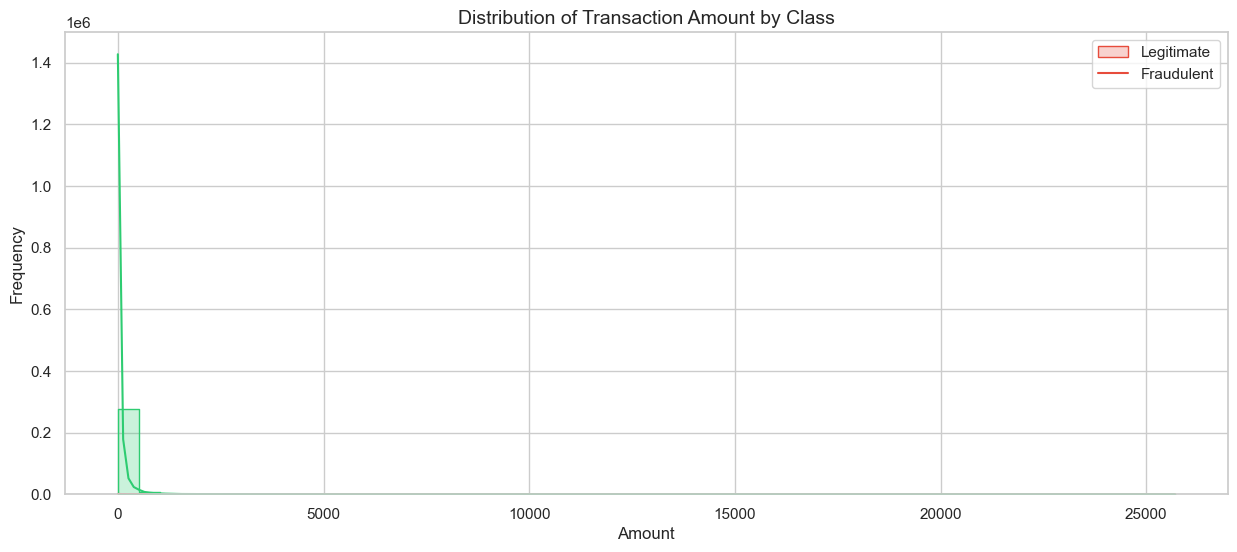

In [6]:
# Analyze Time and Amount features
plt.figure(figsize=(18, 7))

# Time distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df_raw, x='Time', bins=48, kde=True)
plt.title('Distribution of Time', fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

# Amount distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df_raw, x='Amount', bins=50, kde=True)
plt.title('Distribution of Transaction Amount', fontsize=14)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze Amount with log scale (often better for financial data)
plt.figure(figsize=(12, 6))
sns.histplot(data=df_raw, x='Amount', bins=50, kde=True, log_scale=True)
plt.title('Distribution of Transaction Amount (Log Scale)', fontsize=14)
plt.xlabel('Amount (log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

# Comparing Amount distributions by class
plt.figure(figsize=(15, 6))
sns.histplot(data=df_raw, x='Amount', hue='Class', bins=50, kde=True, element="step", 
             common_norm=False, palette=['#2ecc71', '#e74c3c'])
plt.title('Distribution of Transaction Amount by Class', fontsize=14)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(['Legitimate', 'Fraudulent'])
plt.grid(True)
plt.show()

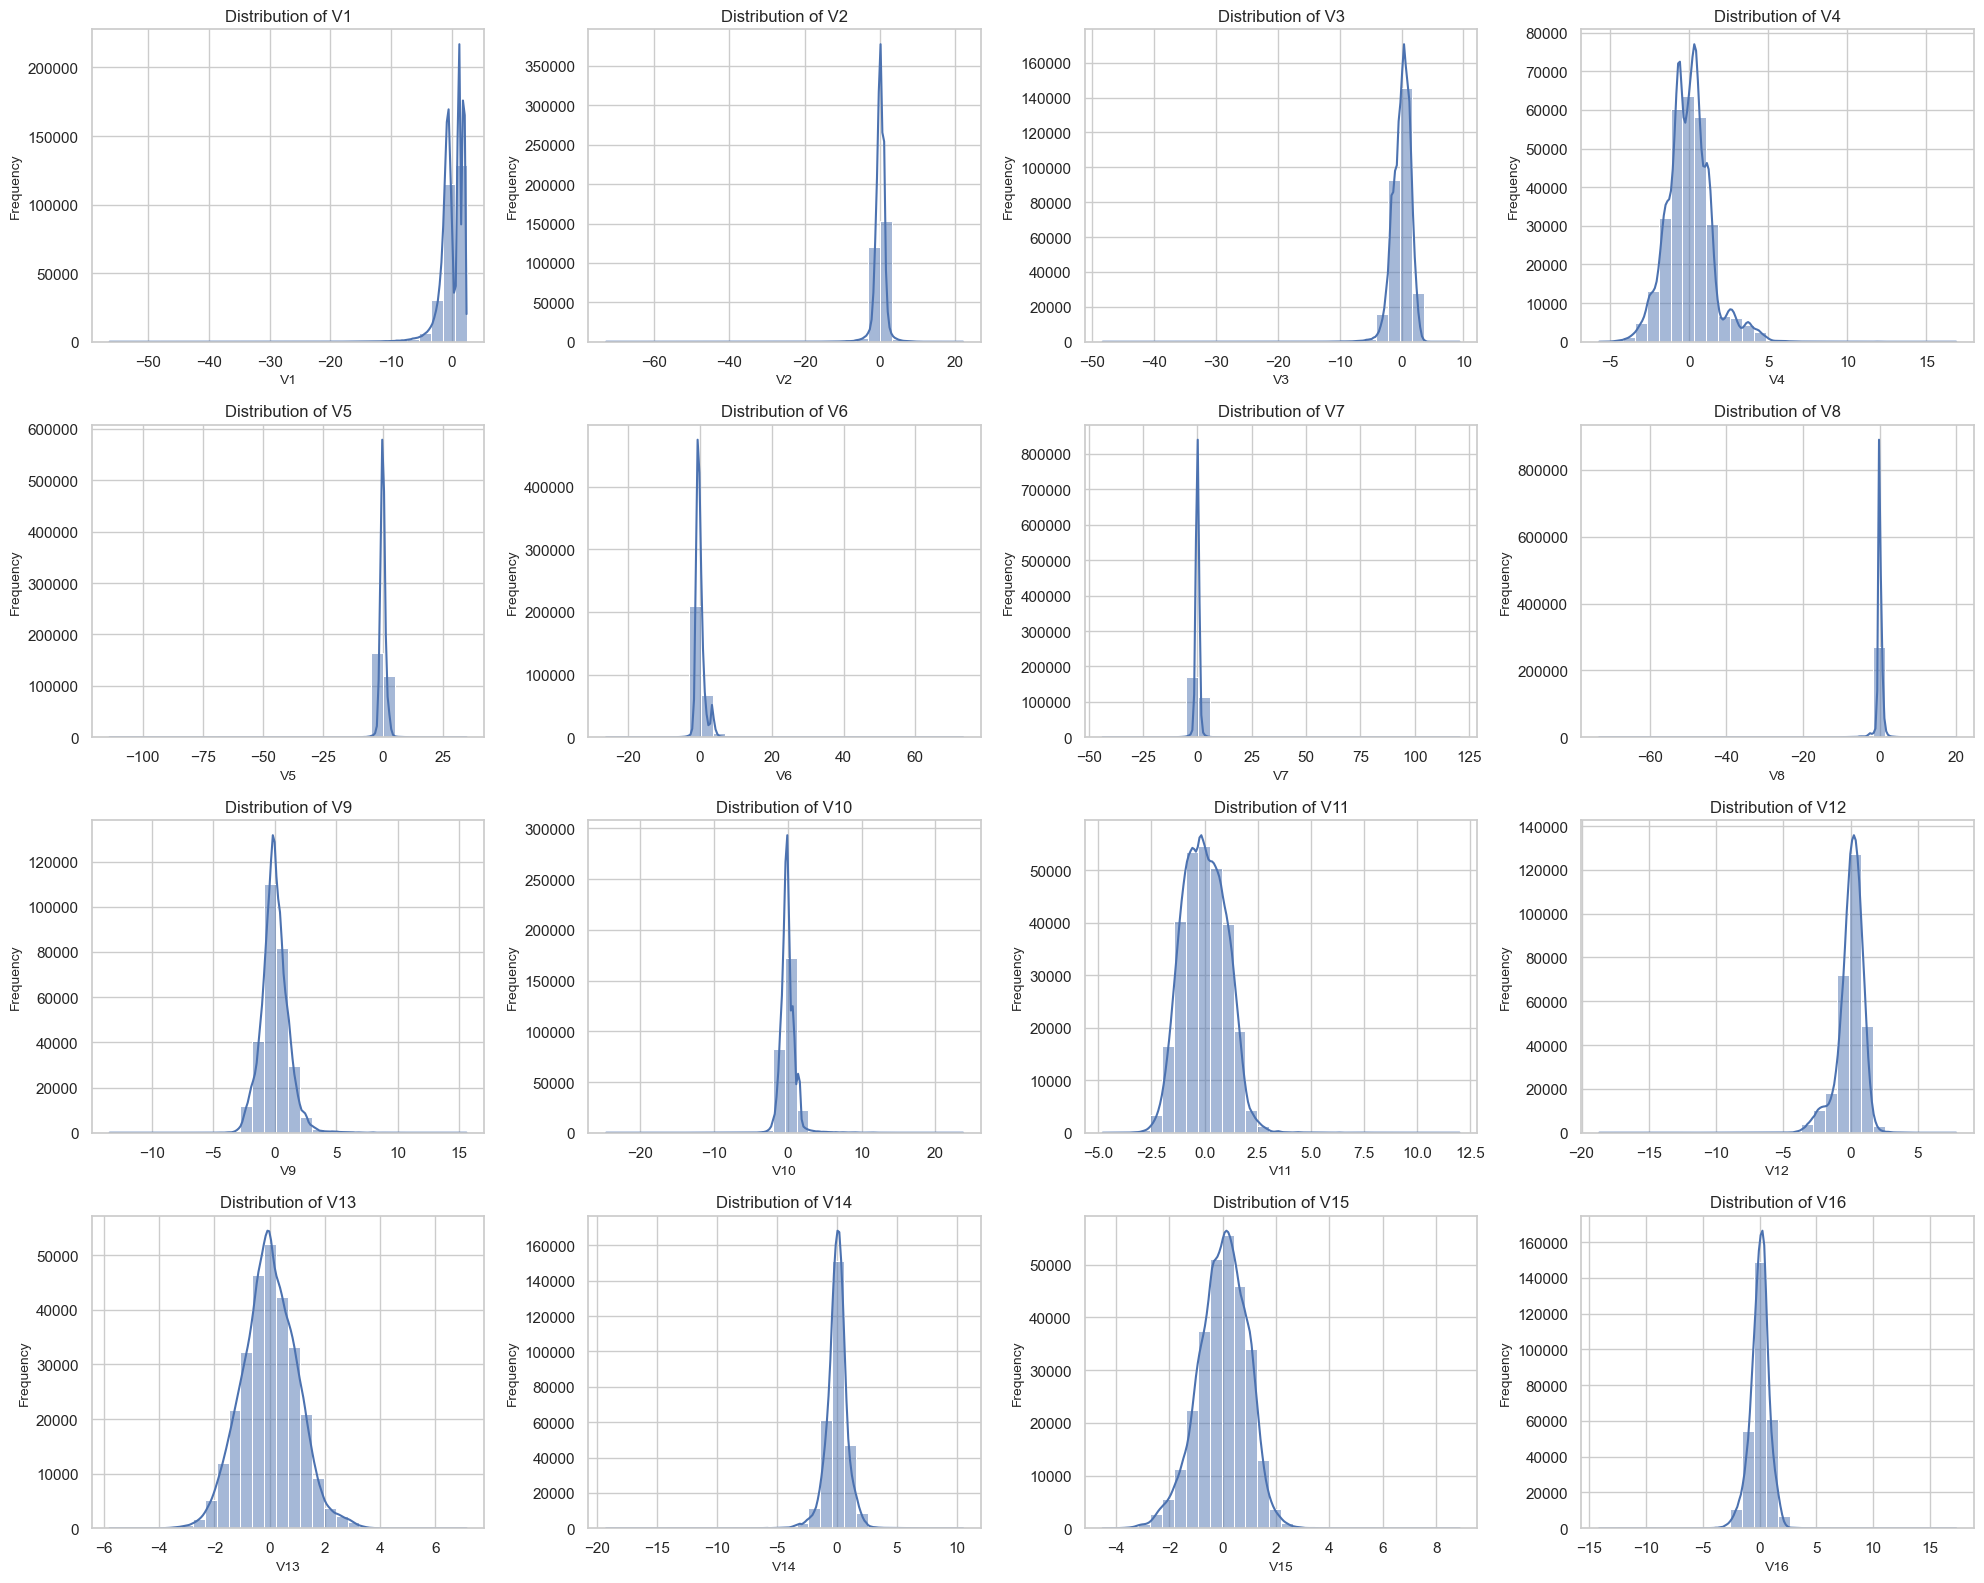

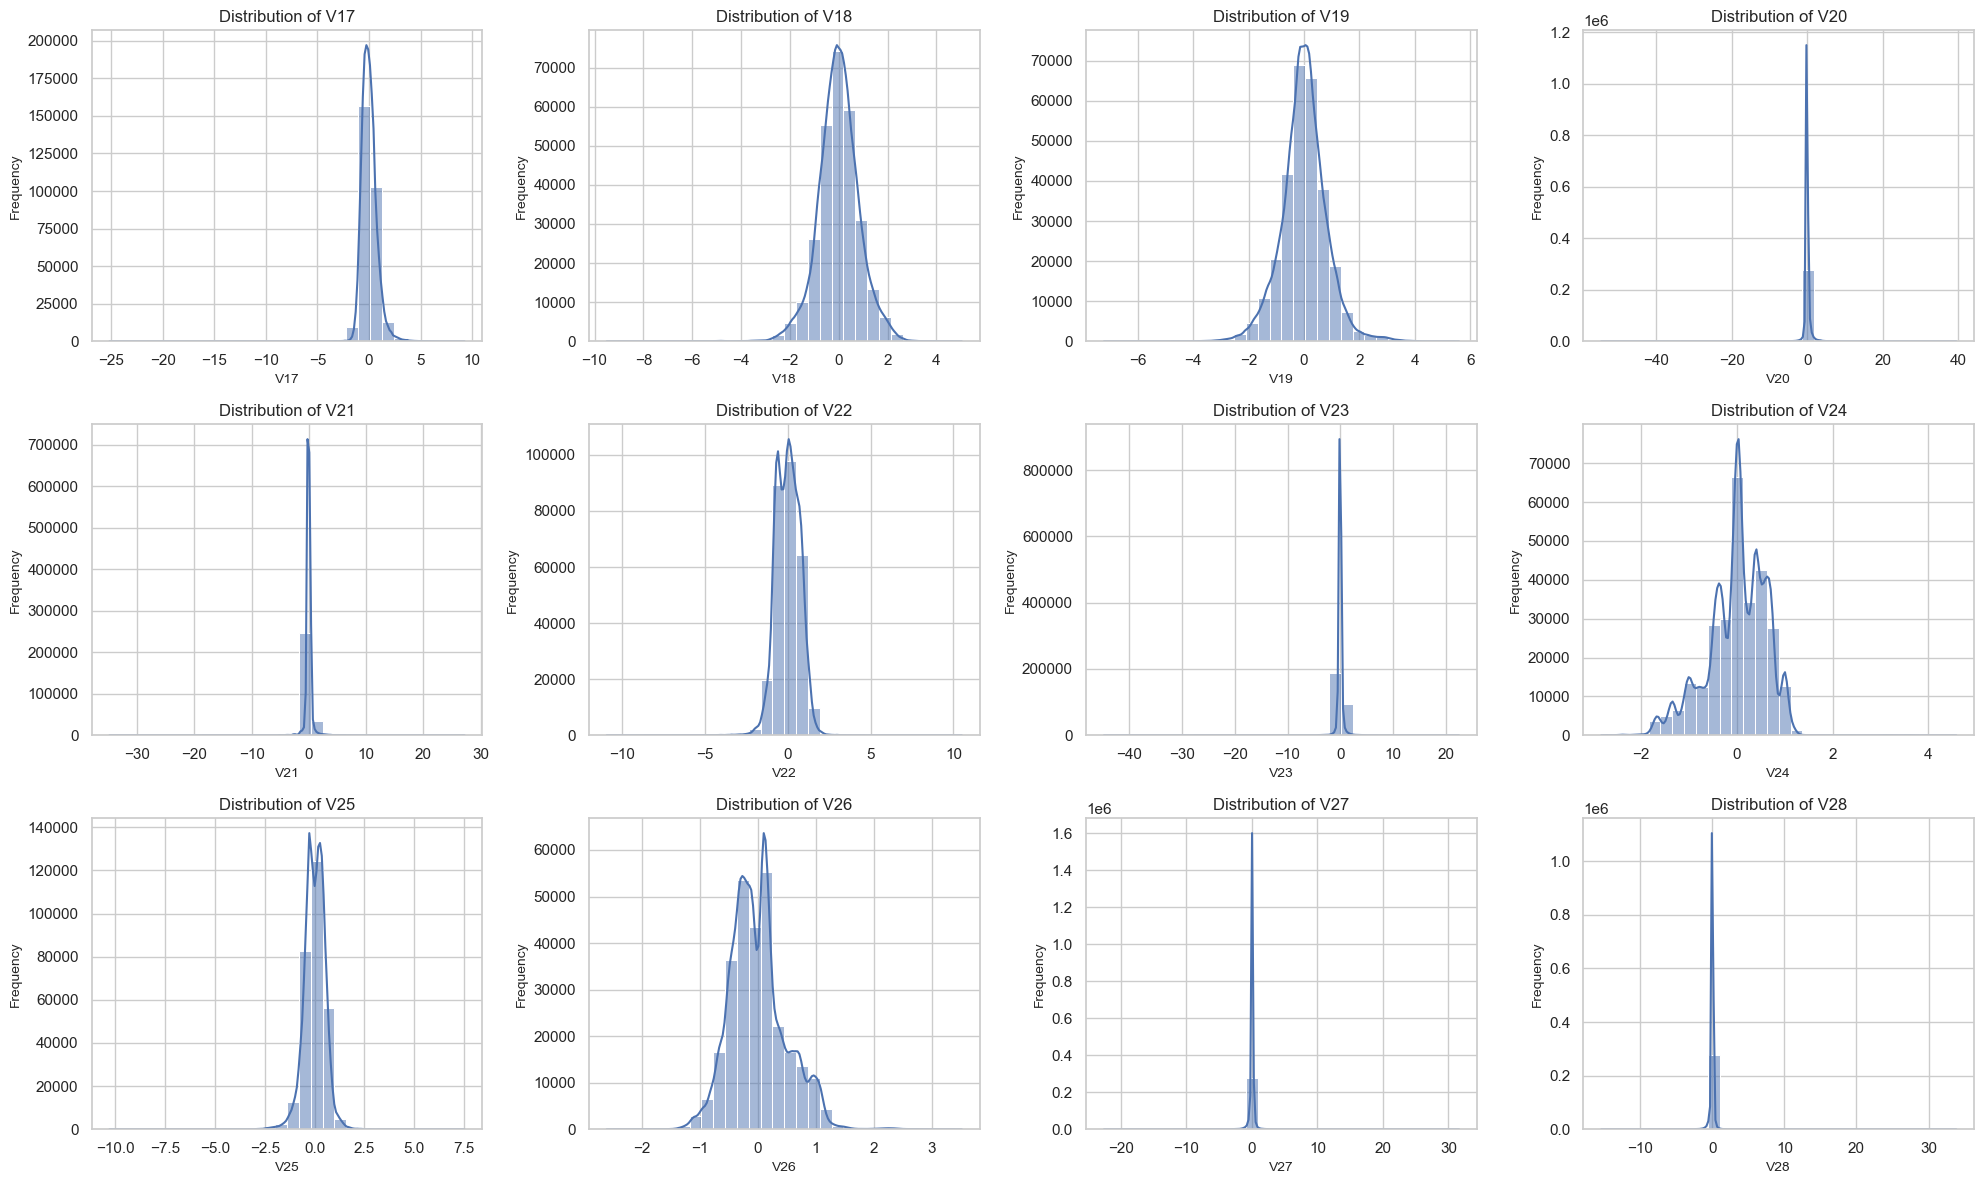

2025-09-24 21:55:08,928 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:55:09,020 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:55:09,020 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:55:09,170 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 21:55:09,

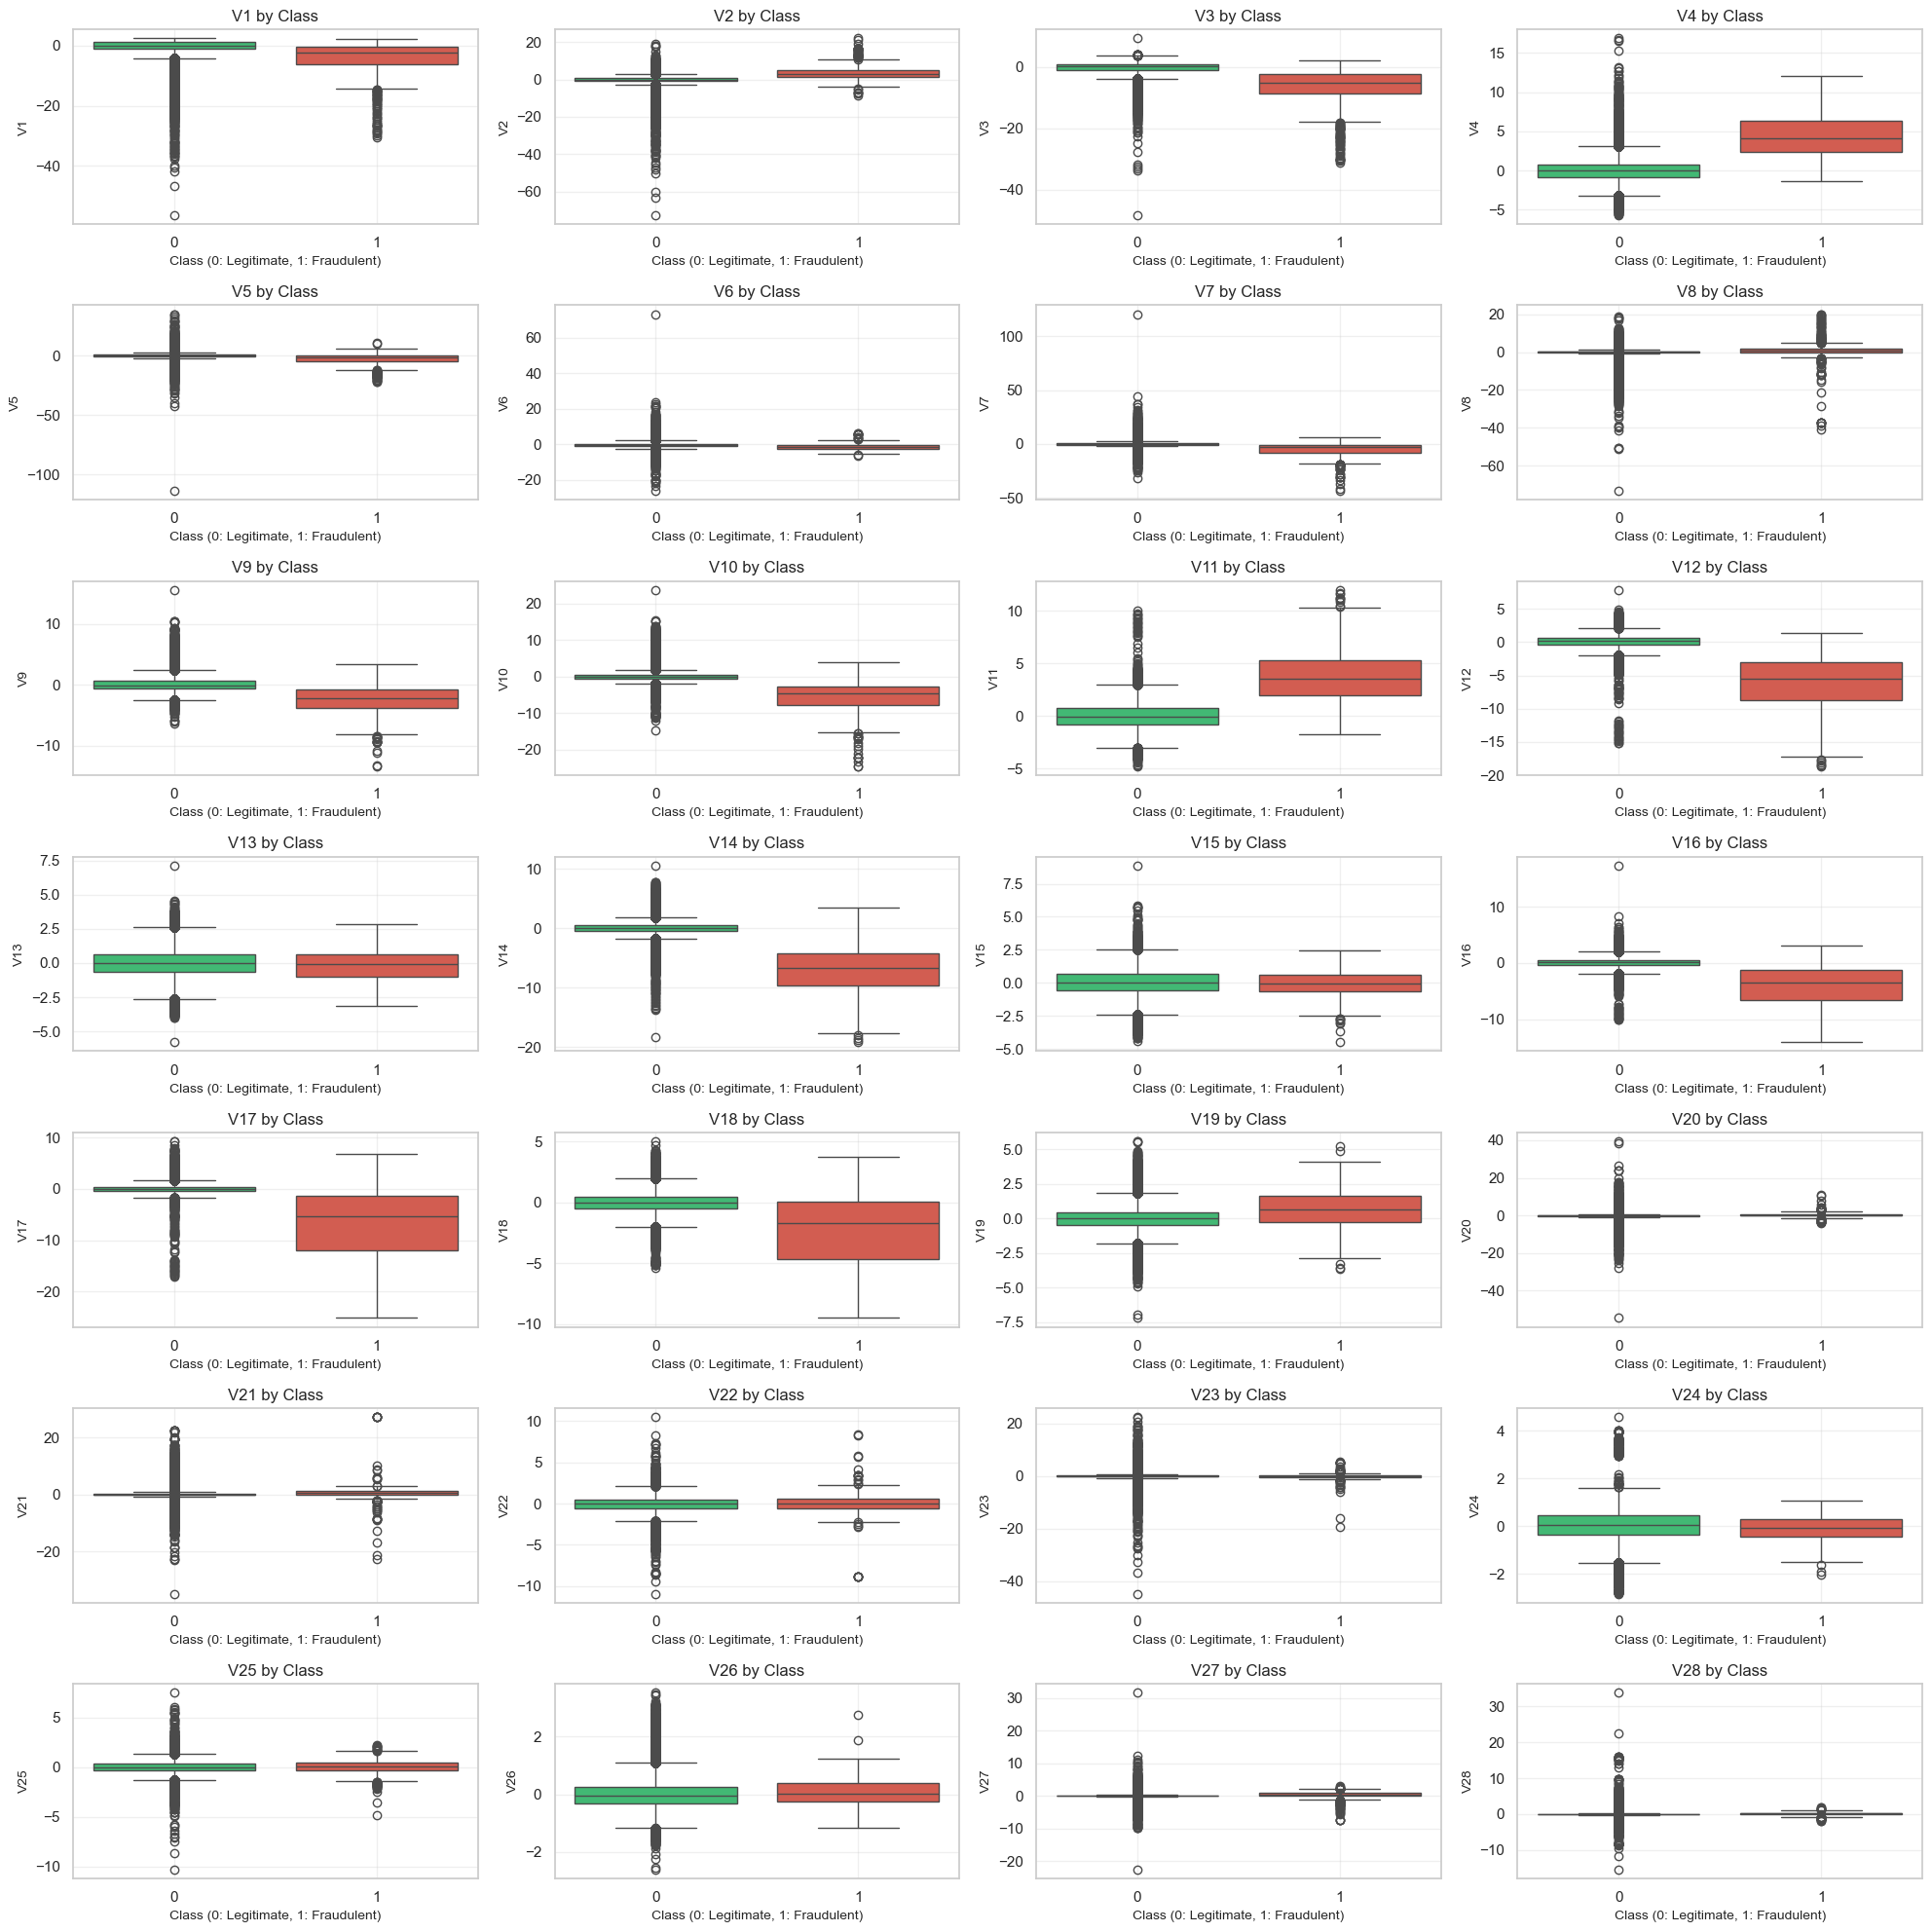

In [7]:
# Analyze distributions of V1-V28 features
# We'll create a grid of distribution plots for each feature

# Function to create distribution plots for groups of features
def plot_feature_distributions(df, features, rows=4, cols=4, figsize=(20, 16)):
    plt.figure(figsize=figsize)
    
    for i, feature in enumerate(features):
        if i < rows * cols:
            plt.subplot(rows, cols, i+1)
            sns.histplot(data=df, x=feature, bins=30, kde=True)
            plt.title(f'Distribution of {feature}', fontsize=12)
            plt.xlabel(feature, fontsize=10)
            plt.ylabel('Frequency', fontsize=10)
            plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Get V1-V28 features
v_features = [col for col in df_raw.columns if col.startswith('V')]

# Plot distributions in groups of 16
plot_feature_distributions(df_raw, v_features[:16], rows=4, cols=4, figsize=(20, 16))
plot_feature_distributions(df_raw, v_features[16:], rows=3, cols=4, figsize=(20, 12))

# Compare V-feature distributions by class
# We'll create boxplots to compare the distributions between fraud and non-fraud classes
# This will help identify which features are most discriminative

plt.figure(figsize=(20, 20))
for i, feature in enumerate(v_features):
    plt.subplot(7, 4, i+1)
    sns.boxplot(x='Class', y=feature, data=df_raw, palette=['#2ecc71', '#e74c3c'])
    plt.title(f'{feature} by Class', fontsize=12)
    plt.xlabel('Class (0: Legitimate, 1: Fraudulent)', fontsize=10)
    plt.ylabel(feature, fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Time Analysis

Let's analyze the temporal patterns in the transactions to understand if there are any trends or patterns related to time.

2025-09-24 22:06:22,160 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 22:06:22,164 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 22:06:22,164 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


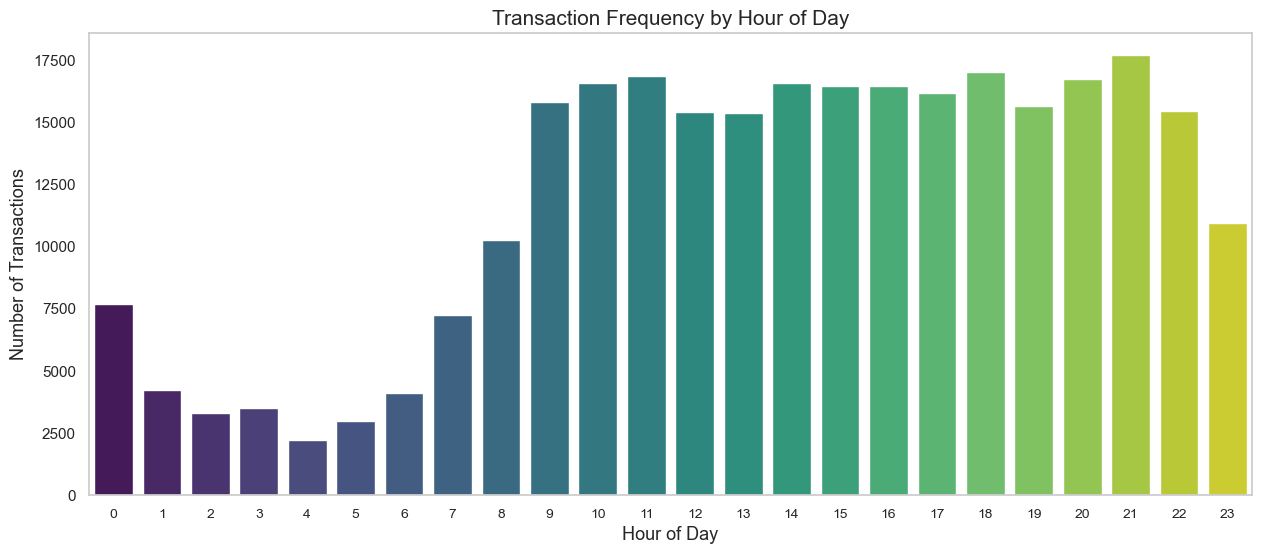

2025-09-24 22:06:22,462 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 22:06:22,466 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 22:06:22,466 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


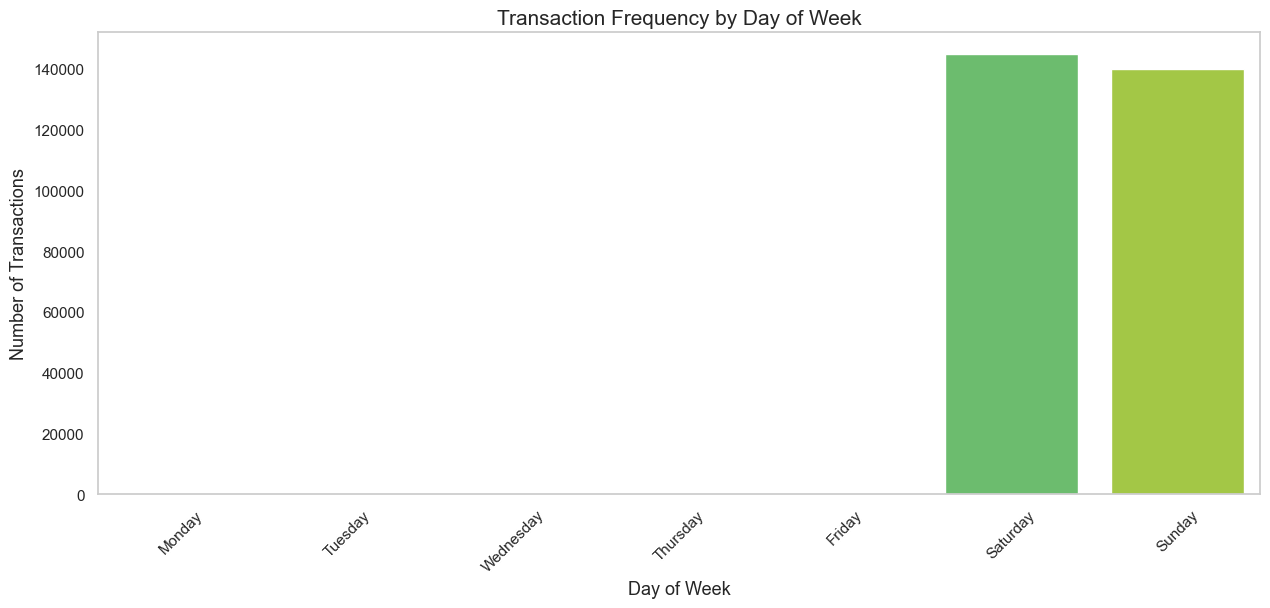

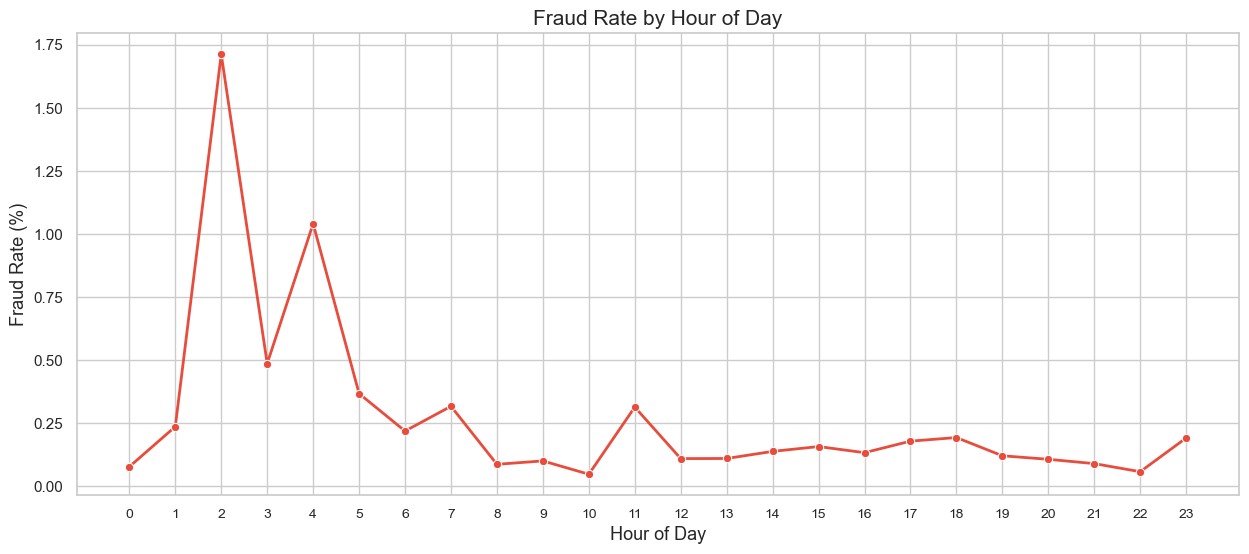

2025-09-24 22:06:22,653 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 22:06:22,656 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-24 22:06:22,656 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


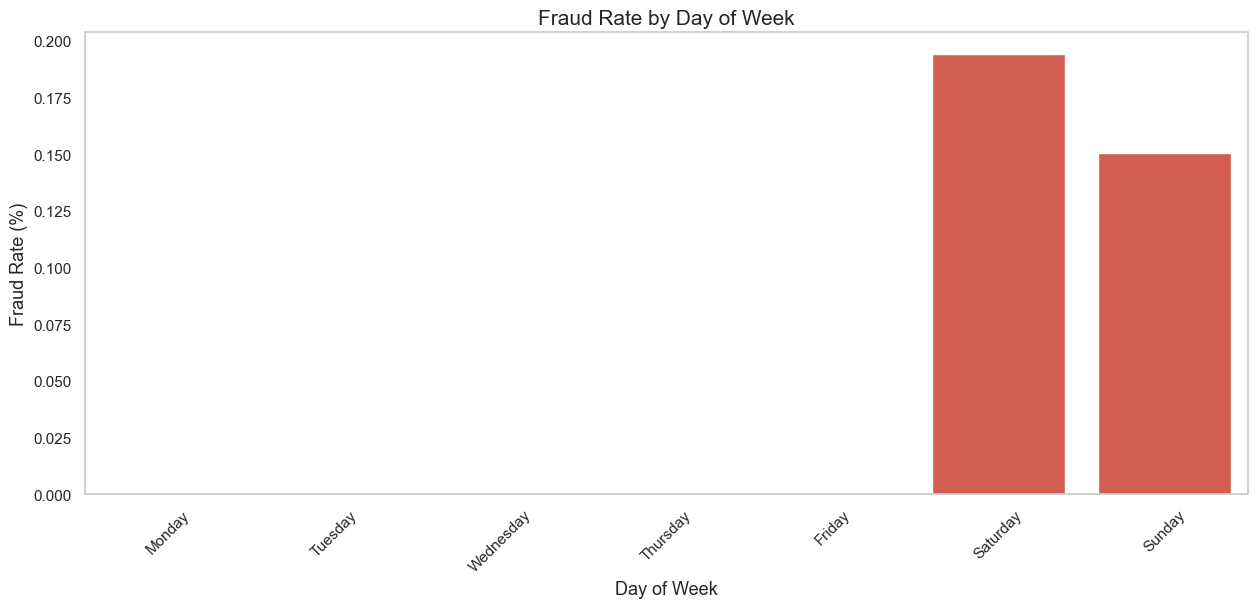

In [10]:
# Convert 'Time' to a more interpretable format
# Assuming Time is seconds from the first transaction
# We'll create a reference date and add the seconds

REF_DATE = datetime(2000, 1, 1)  # Arbitrary reference date
df_raw['transaction_datetime'] = df_raw['Time'].apply(
    lambda x: REF_DATE + timedelta(seconds=float(x)) if not pd.isna(x) else None
)

# Extract time components
df_raw['hour_of_day'] = df_raw['transaction_datetime'].dt.hour
df_raw['day_of_week'] = df_raw['transaction_datetime'].dt.dayofweek
df_raw['is_weekend'] = df_raw['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Define day order for consistent plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Create day_name as categorical with proper order
df_raw['day_name'] = pd.Categorical(
    df_raw['transaction_datetime'].dt.day_name(),
    categories=day_order,
    ordered=True
)

# Disable the specific matplotlib warnings we're encountering
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib.category')

# Analyze transaction frequency by hour of day
plt.figure(figsize=(15, 6))
hour_counts = df_raw.groupby('hour_of_day')['Time'].count()
ax = sns.barplot(x=hour_counts.index.astype(str), y=hour_counts.values, palette='viridis')
plt.title('Transaction Frequency by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=13)
plt.ylabel('Number of Transactions', fontsize=13)
plt.xticks(range(24), range(24), fontsize=10)
plt.grid(axis='y')
plt.show()

# Analyze transaction frequency by day of week
plt.figure(figsize=(15, 6))
# Create a pivot table that ensures all days are included in the right order
day_counts = df_raw.groupby('day_name')['Time'].count().reset_index()
# Plot with explicit order parameter
ax = sns.barplot(x='day_name', y='Time', data=day_counts, palette='viridis')
plt.title('Transaction Frequency by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=13)
plt.ylabel('Number of Transactions', fontsize=13)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

# Analyze fraud distribution by hour of day
plt.figure(figsize=(15, 6))
hour_fraud = df_raw.groupby('hour_of_day')['Class'].mean() * 100
sns.lineplot(x=hour_fraud.index.astype(str), y=hour_fraud.values, marker='o', linewidth=2, color='#e74c3c')
plt.title('Fraud Rate by Hour of Day', fontsize=15)
plt.xlabel('Hour of Day', fontsize=13)
plt.ylabel('Fraud Rate (%)', fontsize=13)
plt.xticks(range(24), range(24), fontsize=10)
plt.grid(True)
plt.show()

# Analyze fraud distribution by day of week
plt.figure(figsize=(15, 6))
# Calculate fraud rate by day and ensure all days are in the right order
day_fraud = df_raw.groupby('day_name')['Class'].mean().reset_index()
day_fraud['Class'] = day_fraud['Class'] * 100  # Convert to percentage
# Plot with explicit order parameter
ax = sns.barplot(x='day_name', y='Class', data=day_fraud, color='#e74c3c')
plt.title('Fraud Rate by Day of Week', fontsize=15)
plt.xlabel('Day of Week', fontsize=13)
plt.ylabel('Fraud Rate (%)', fontsize=13)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

## 6. Correlation Analysis

Let's analyze the correlations between features to identify potential relationships and dependencies.

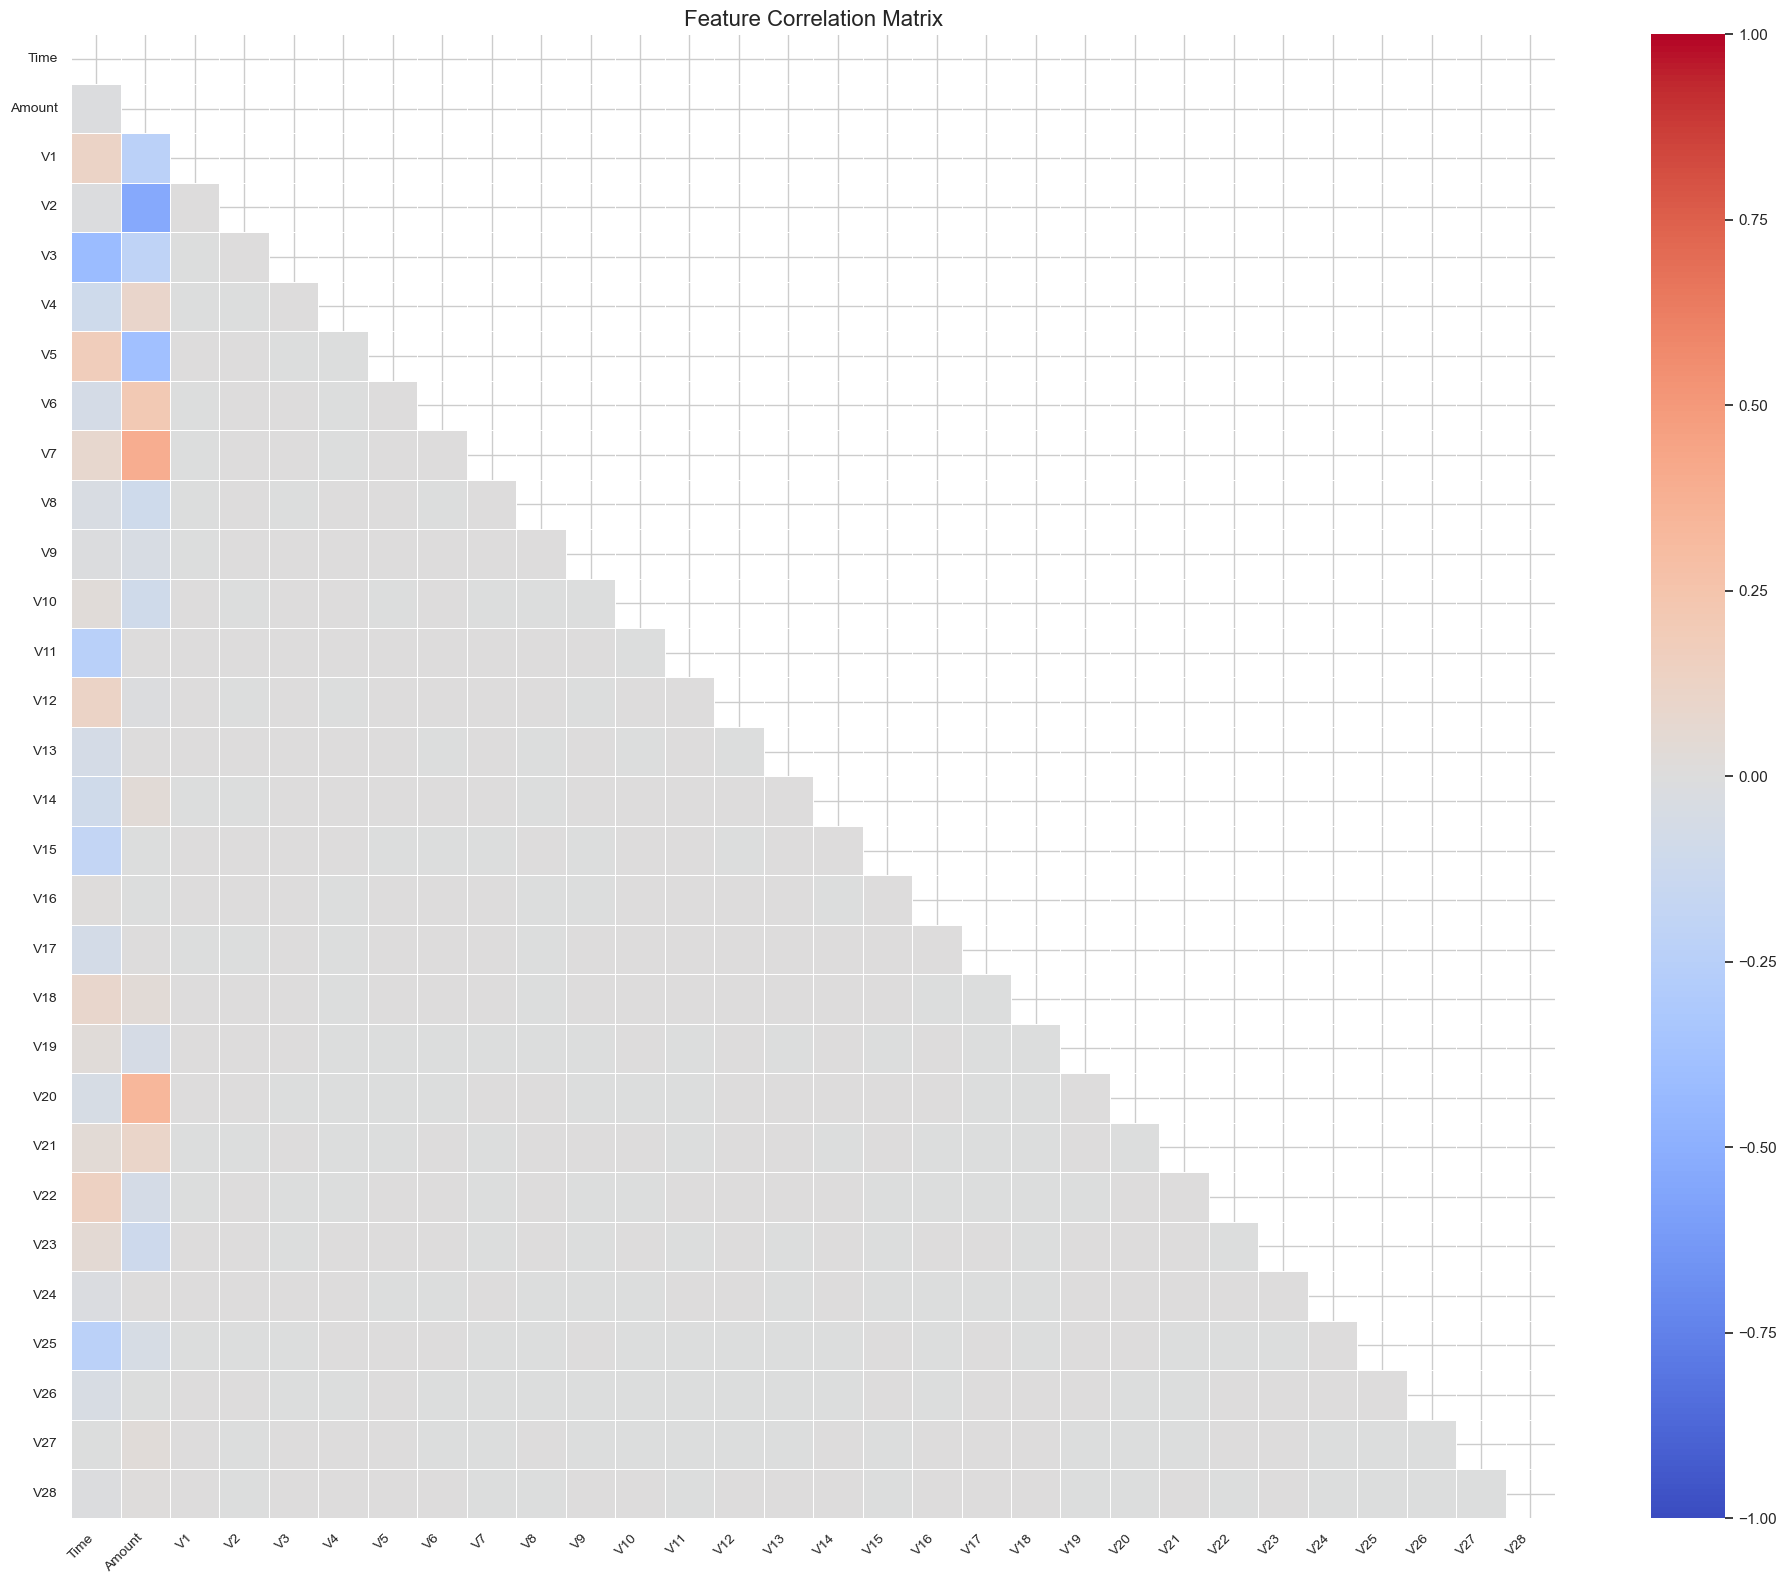

KeyError: 'Class'

In [11]:
# Calculate correlation matrix for numeric features
numeric_cols = ['Time', 'Amount'] + [col for col in df_raw.columns if col.startswith('V')]
correlation_matrix = df_raw[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, square=True)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Calculate correlations with the target (Class)
class_correlations = correlation_matrix['Class'].drop('Class').sort_values(ascending=False)
top_pos_corr = class_correlations.nlargest(10)
top_neg_corr = class_correlations.nsmallest(10)

# Plot top correlations with Class
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
sns.barplot(x=top_pos_corr.values, y=top_pos_corr.index, palette='Reds_r')
plt.title('Top 10 Positive Correlations with Fraud', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x')
plt.xlim(0, 1)

plt.subplot(2, 1, 2)
sns.barplot(x=top_neg_corr.values, y=top_neg_corr.index, palette='Blues')
plt.title('Top 10 Negative Correlations with Fraud', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x')
plt.xlim(-1, 0)

plt.tight_layout()
plt.show()

## 7. Feature Engineering Exploration

Let's explore some of the feature engineering techniques we'll use in our preprocessing pipeline.

User Aggregates Sample (first 5 users):


,user_id,user_avg_amount,user_tx_count,user_amount_std
0,0,127.495,38,317.910
1,1,183.492,26,534.309
2,2,81.153,27,141.535
3,3,165.551,37,548.269
4,4,75.967,36,270.490



Merchant Risk Scores (top 10 by risk):


,merchant_category,merchant_risk_score
52,52,0.004
93,93,0.004
99,99,0.004
69,69,0.004
85,85,0.004
40,40,0.003
98,98,0.003
16,16,0.003
90,90,0.003
43,43,0.003


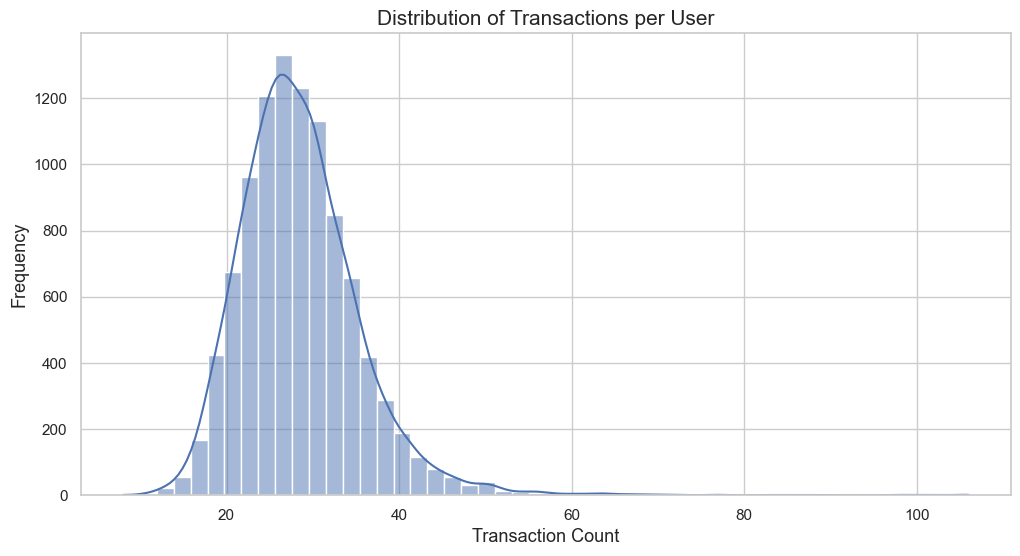

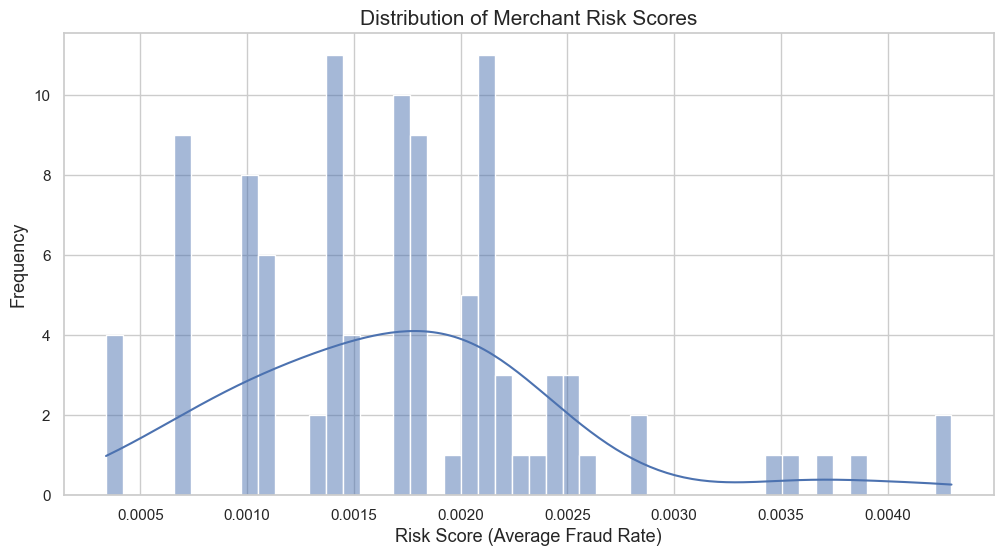

In [12]:
# Create a synthetic user_id based on patterns in the V features
# We'll use a combination of V1, V2, V3 to create a synthetic user_id
v_subset = ['V1', 'V2', 'V3']
df_raw['user_id'] = df_raw[v_subset].apply(
    lambda row: hash(tuple(row.values.round(2))), axis=1
) % 10000  # Limit to a reasonable number of synthetic users

# Simulate merchant category based on V features
df_raw['merchant_category'] = df_raw[['V5', 'V6', 'V7']].apply(
    lambda row: hash(tuple(row.values.round(2))), axis=1
) % 100  # Limit to 100 merchant categories

# Calculate user aggregates
user_aggregates = df_raw.groupby('user_id').agg(
    user_avg_amount=('Amount', 'mean'),
    user_tx_count=('Amount', 'count'),
    user_amount_std=('Amount', 'std')
).reset_index()

# Calculate merchant risk score
merchant_risk = df_raw.groupby('merchant_category')['Class'].mean().reset_index()
merchant_risk.rename(columns={'Class': 'merchant_risk_score'}, inplace=True)

# Display user aggregates
print("User Aggregates Sample (first 5 users):")
display(user_aggregates.head())

# Display merchant risk scores
print("\nMerchant Risk Scores (top 10 by risk):")
display(merchant_risk.sort_values('merchant_risk_score', ascending=False).head(10))

# Visualize user transaction count distribution
plt.figure(figsize=(12, 6))
sns.histplot(user_aggregates['user_tx_count'], bins=50, kde=True)
plt.title('Distribution of Transactions per User', fontsize=15)
plt.xlabel('Transaction Count', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.grid(True)
plt.show()

# Visualize merchant risk distribution
plt.figure(figsize=(12, 6))
sns.histplot(merchant_risk['merchant_risk_score'], bins=50, kde=True)
plt.title('Distribution of Merchant Risk Scores', fontsize=15)
plt.xlabel('Risk Score (Average Fraud Rate)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.grid(True)
plt.show()

## 8. Test the Preprocessing Pipeline

Let's test our preprocessing pipeline to ensure it works as expected.

## Note on Data Flow and Files

This notebook follows the standard exploratory data analysis workflow, starting with raw data (`transactions_raw.csv`) rather than using already processed data (`transactions_processed.csv`). This approach is intentional for several reasons:

1. **Transparency**: By starting with raw data, we document and demonstrate every transformation applied to create the processed dataset.

2. **Educational Purpose**: This notebook serves as documentation of the complete preprocessing pipeline, showing how features are derived.

3. **Reproducibility**: Anyone running this notebook will get the same processed output, regardless of what's in the processed data file.

4. **Feature Development**: We can experiment with new preprocessing steps and features before updating the official processed dataset.

In a production scenario, if you want to skip the preprocessing steps and directly use the processed data, you would:

```python
# Load the processed data directly
processed_df = pd.read_csv(project_root / 'data' / 'processed' / 'transactions_processed.csv')
```

The processed data file (`transactions_processed.csv`) is typically used by downstream applications like model training scripts, API services, or real-time fraud detection systems - not by the EDA notebook itself.

In [13]:
# Apply the preprocessing pipeline
print("Applying the preprocessing pipeline...")

# Clean the data
print("\nCleaning data...")
cleaned_df = clean(df_raw)
print(f"Shape after cleaning: {cleaned_df.shape}")

# Engineer features
print("\nEngineering features...")
processed_df = feature_engineer(cleaned_df)
print(f"Shape after feature engineering: {processed_df.shape}")

# Display the first few rows of the processed data
print("\nPreprocessed data sample:")
display(processed_df.head())

# Display the list of all features in the processed data
print("\nList of features in the processed data:")
display(pd.DataFrame({'Features': processed_df.columns}))

# Optional: Save the processed data
PROCESSED_DATA_PATH = project_root / 'data' / 'processed' / 'transactions_processed.csv'
print(f"\nSaving processed data to {PROCESSED_DATA_PATH}...")
try:
    save_processed(processed_df, PROCESSED_DATA_PATH)
    print("Successfully saved processed data.")
except Exception as e:
    print(f"Error saving processed data: {e}")
    print("Skipping save operation.")

2025-09-24 22:06:38,299 - src.features.preprocess - INFO - Cleaning raw data
2025-09-24 22:06:38,322 - src.features.preprocess - INFO - Original data shape: (284807, 38)
2025-09-24 22:06:38,322 - src.features.preprocess - INFO - Original data shape: (284807, 38)


Applying the preprocessing pipeline...

Cleaning data...


2025-09-24 22:06:38,751 - src.features.preprocess - WARNING - Found 1081 duplicate rows, removing
2025-09-24 22:06:39,189 - src.features.preprocess - INFO - After cleaning: (283726, 38) (removed 1081 rows)
2025-09-24 22:06:39,189 - src.features.preprocess - INFO - Engineering features
2025-09-24 22:06:39,189 - src.features.preprocess - INFO - After cleaning: (283726, 38) (removed 1081 rows)
2025-09-24 22:06:39,189 - src.features.preprocess - INFO - Engineering features
2025-09-24 22:06:39,213 - src.features.preprocess - INFO - Successfully loaded feature definitions from c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\src\features\feature_defs.yml
2025-09-24 22:06:39,213 - src.features.preprocess - INFO - Successfully loaded feature definitions from c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\src\features\feature_defs.yml


Shape after cleaning: (283726, 38)

Engineering features...


2025-09-24 22:06:40,608 - src.features.preprocess - WARNING - Large dataset detected (283,726 rows). Transaction velocity calculation may take a long time.
2025-09-24 22:06:40,609 - src.features.preprocess - WARNING - Consider using --use-gpu flag for faster processing or --skip-velocity-calculation for very large datasets.
2025-09-24 22:06:40,609 - src.features.preprocess - INFO - Calculating transaction velocities (optimized CPU method)...
2025-09-24 22:06:40,609 - src.features.preprocess - WARNING - Consider using --use-gpu flag for faster processing or --skip-velocity-calculation for very large datasets.
2025-09-24 22:06:40,609 - src.features.preprocess - INFO - Calculating transaction velocities (optimized CPU method)...
2025-09-24 22:06:40,666 - src.features.preprocess - INFO - Processing user 1/10000 (0.0%)
2025-09-24 22:06:40,666 - src.features.preprocess - INFO - Processing user 1/10000 (0.0%)
2025-09-24 22:06:42,720 - src.features.preprocess - INFO - Processing user 1001/1000

Shape after feature engineering: (283726, 45)

Preprocessed data sample:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_datetime,hour_of_day,day_of_week,day_name,is_weekend,user_id,merchant_category,amount_scaled,user_avg_amount,user_tx_count,user_amount_std,time_since_last_tx,tx_velocity_1h,merchant_risk_score
0,3804.0,1.321,0.559,0.133,0.687,0.245,-0.518,0.080,-0.320,1.142,-0.697,0.394,-1.729,3.551,0.791,0.248,0.621,0.335,0.058,-0.096,-6.362e-04,-0.476,-1.043,0.019,-0.527,0.357,0.103,-0.041,0.019,0.89,0,2000-01-01 01:03:24,1,5,Saturday,1,0,72,-1.519,0.794,38,0.792,5.202,-0.544,1.090e-03
1,40052.0,1.193,0.342,0.285,1.132,-0.220,-0.938,0.313,-0.290,-0.152,-0.023,-0.244,0.651,0.869,0.223,0.828,0.012,-0.474,-0.253,-0.386,-3.330e-02,0.054,0.183,-0.133,0.423,0.707,-0.334,0.014,0.027,31.46,0,2000-01-01 11:07:32,11,5,Saturday,1,0,56,0.197,0.794,38,0.792,0.296,-0.544,6.904e-04
2,46579.0,1.194,0.345,0.286,1.132,-0.219,-0.938,0.312,-0.289,-0.152,-0.023,-0.244,0.651,0.869,0.223,0.828,0.011,-0.474,-0.253,-0.385,-3.519e-02,0.053,0.184,-0.132,0.423,0.707,-0.334,0.014,0.027,30.53,0,2000-01-01 12:56:19,12,5,Saturday,1,0,56,0.179,0.794,38,0.792,-0.175,-0.544,6.904e-04
3,48455.0,0.934,-0.627,0.977,0.706,-0.847,0.696,-0.738,0.398,0.794,-0.137,0.766,0.706,-0.744,-0.029,-0.129,0.211,-0.220,0.030,-0.011,3.494e-02,0.015,-0.016,-0.067,-0.276,0.135,0.341,0.006,0.025,104.22,0,2000-01-01 13:27:35,13,5,Saturday,1,0,7,0.907,0.794,38,0.792,-0.249,0.122,2.139e-03
4,48900.0,-1.119,1.321,1.516,1.207,-0.533,-0.944,0.570,0.178,-1.053,-0.425,-0.056,0.233,0.220,0.623,1.246,-0.482,0.329,-0.025,0.617,-4.587e-02,0.179,0.373,-0.292,0.954,0.412,-0.193,-0.129,-0.039,47.00,0,2000-01-01 13:35:00,13,5,Saturday,1,0,56,0.433,0.794,38,0.792,-0.271,0.789,6.904e-04



List of features in the processed data:


,Features
0,Time
1,V1
2,V2
3,V3
4,V4
5,V5
6,V6
7,V7
8,V8
9,V9


2025-09-24 22:07:00,804 - src.features.preprocess - INFO - Saving processed data to c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\processed\transactions_processed.csv



Saving processed data to c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\processed\transactions_processed.csv...


2025-09-24 22:07:05,970 - src.features.preprocess - INFO - Successfully saved 283726 rows to c:\Users\satyam\Desktop\ai-projects\real-time-fraud-detection\data\processed\transactions_processed.csv


Successfully saved processed data.


In [ ]:
# Alternative: Loading pre-processed data directly
# Uncomment the code below if you want to skip preprocessing and use the already processed data

"""
print("Loading pre-processed data directly...")
PROCESSED_DATA_PATH = project_root / 'data' / 'processed' / 'transactions_processed.csv'

try:
    processed_df = pd.read_csv(PROCESSED_DATA_PATH)
    print(f"Successfully loaded processed data from {PROCESSED_DATA_PATH}")
    print(f"Data shape: {processed_df.shape}")
    
    # Display the first few rows of the processed data
    print("\nPreprocessed data sample:")
    display(processed_df.head())
    
    # Display the list of all features in the processed data
    print("\nList of features in the processed data:")
    display(pd.DataFrame({'Features': processed_df.columns}))
    
except Exception as e:
    print(f"Error loading processed data: {e}")
    print("Proceeding with processing the raw data instead.")
"""

## 9. Summary and Conclusions

Based on our exploratory data analysis, we can draw the following conclusions:

1. **Data Structure**:
   - The dataset contains transaction data with 31 features including Time, V1-V28, Amount, and Class
   - V1-V28 are anonymized features from PCA transformation
   - Class is the target variable (0 for legitimate, 1 for fraud)

2. **Class Imbalance**:
   - The dataset is highly imbalanced with fraudulent transactions making up a very small percentage of the total
   - This imbalance will require special handling during model training (e.g., class weighting, sampling techniques)

3. **Missing Values**:
   - The dataset contains some missing values that need to be imputed
   - Median imputation is used for numeric features to handle outliers

4. **Time Patterns**:
   - Time-related features show different patterns for fraudulent vs. legitimate transactions
   - Hour of day and day of week features will be valuable for the model

5. **Amount Distribution**:
   - Transaction amounts are right-skewed
   - Log transformation helps normalize the distribution
   - Fraudulent transactions tend to have different amount distributions than legitimate ones

6. **Feature Correlations**:
   - Several V-features show strong correlations with the fraud label
   - Some features are correlated with each other, which may be due to the PCA transformation

7. **Feature Engineering**:
   - Time-based features (hour, day, weekend) improve model performance
   - User aggregates capture spending patterns
   - Merchant risk scores capture merchant-specific fraud risks

Our preprocessing pipeline effectively handles missing values, normalizes distributions, and creates informative engineered features that will help the model identify fraudulent transactions.

Next steps include:
1. Model selection and training
2. Model evaluation and optimization
3. Deployment for real-time fraud detection